# **Imports**

In [2]:
from utils_models import *
from utils_dataloaders import *
from utils_training import *

import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

##### set dataframe display options 
# show decimal format (not scientific notation)
pd.options.display.float_format = '{:.4f}'.format

# display all columns
pd.set_option('display.max_columns', None)

# **Multimodal DataLoader Example**

label
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 7])  |  0.0  |  1.0
geo
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 256, 256])  |  1.0  |  7.0
rgb
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 3, 256, 256])  |  3.1325292587280273  |  204.62545776367188
dem
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 256, 256])  |  597.962646484375  |  610.0032348632812
ep
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 256, 256])  |  3.858466625213623  |  91.63953399658203


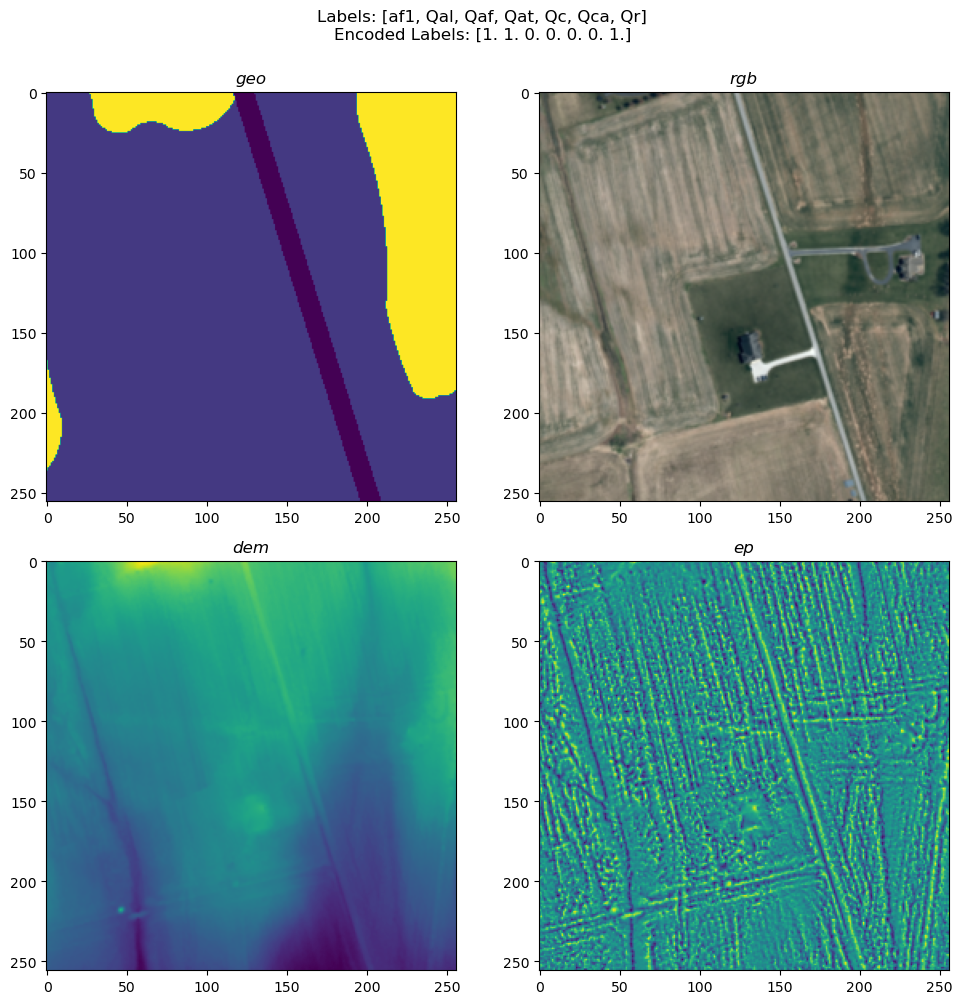

In [4]:
#######################################
# Verify Dataset and DataLoader Output
#######################################

# get list of patch IDs
patch_ids_path = r'../data/patches_warren/patch_ids.csv'    # path to patch id csv
patch_ids = pd.read_csv(patch_ids_path, header=None)         # read csv as df
ids = patch_ids.iloc[:,0]

# directory where patches are located
data_dir = r'../data/patches_warren'

# modality names and unique identifier filename substrings to use.
modalities = {
    'geo': ['geology.tif'],
    
    'rgb': ['aerialr.tif', 
            'aerialg.tif', 
            'aerialb.tif'], 

    'dem': ['dem.tif'], 

    'ep': ['ep_5x5.tif']
              }

# custom multimodal dataset with paired images
example_dataset = MultiModalDataset(ids=ids, 
                                    data_dir=data_dir, 
                                    modalities=modalities, 
                                    norm_params=None, 
                                    augment=True, 
                                    task='classification')


##### example dataloader with batch size of 1 for visualization
example_loader = DataLoader(example_dataset, batch_size=1)
example = next(iter(example_loader))


##### print data report
for modality in example.keys():
    print(modality)
    print(f"{type(example[modality])}  |  {example[modality].dtype}  |  {example[modality].shape}  |  {example[modality].min()}  |  {example[modality].max()}")


##### plot modalities & labels
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.ravel()

idx = 0
for modality in example.keys():
    if not 'label' in modality:
        image = prep_image_for_plot(example[modality][0])
        ax[idx].imshow(image)
        ax[idx].set_title(modality, style='italic')
        idx += 1
    else:
        label_vec = example['label'].numpy().ravel()

plt.suptitle(f"Labels: [af1, Qal, Qaf, Qat, Qc, Qca, Qr]\nEncoded Labels: {label_vec}", y=1)
plt.tight_layout()
plt.show()

# **Parameters**

In [6]:
output_dir = r'../models/classification/test'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

train_val_patch_path = r'../data/warren/patches_256_50.geojson'

val_size = 2048

test_size = 2048

patch_seed = 1


# **Data Selection**

## Model Directory Setup

In [2]:
# model_root = r'../models'
# if not os.path.isdir(model_root):
#     os.makedirs(model_root)

# classification_dir = r'../models/classification'
# if not os.path.isdir(classification_dir):
#     os.makedirs(classification_dir)

# for _, dirs, _ in os.walk(classification_dir):
#     model_number = str(len(dirs) + 1).zfill(2)
#     model_dir = os.path.join(classification_dir, f"model_{model_number}")
#     os.makedirs(model_dir)
#     break


## Patch Selection

### *Training & Validation Patches*

In [7]:
#########################################################
# Select Spatially Independent & Non-Overlapping Patches
#########################################################

##### read patches GeoJSON into geodataframe
gdf = gpd.read_file(train_val_patch_path)


##### select test set
gdf_val, gdf_train = randomly_select_indpendent_patch_sets(gdf, val_size, seed=patch_seed)


##### save validation and training patches
gdf_train.to_file(f"{output_dir}/patches_train.geojson", driver='GeoJSON')
gdf_val.to_file(f"{output_dir}/patches_val.geojson", driver='GeoJSON')

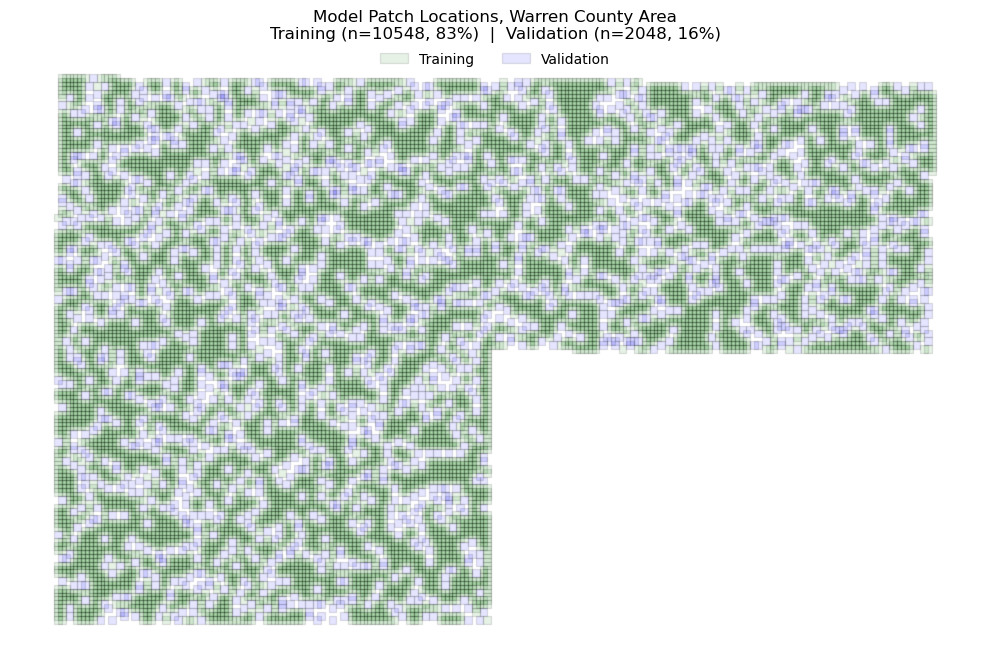

In [9]:
#############################
# Visualize Selected Patches
#############################

##### plot patches
fig, ax = plt.subplots(figsize=(10,8))

# plot
gdf_train.plot(ax=ax, facecolor='green', edgecolor='k', linewidth=1, alpha=0.1, label='Training')
gdf_val.plot(ax=ax, facecolor='blue', edgecolor='k', linewidth=1, alpha=0.1, label='Validation')

# legend
train_patch = Patch(facecolor='green', edgecolor='k', linewidth=1, alpha=0.1, label='Training')
val_patch = Patch(facecolor='blue', edgecolor='k', linewidth=1, alpha=0.1, label='Validation')
ax.legend(handles=[train_patch, val_patch], loc='center', bbox_to_anchor=(0.5, 0.98), frameon=False, ncols=2)

# title
n = len(gdf_train) + len(gdf_val)
train_percent = len(gdf_train) / n * 100
val_percent = len(gdf_val) / n * 100
train_subtitle = f"Training (n={len(gdf_train)}, {int(train_percent)}%)"
val_subtitle = f"Validation (n={len(gdf_val)}, {int(val_percent)}%)"
ax.set_title(f"Model Patch Locations, Warren County Area\n{train_subtitle}  |  {val_subtitle}")

ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"{output_dir}/train_val_patches.jpg")
plt.show()


### *Test Patches*

In [ ]:
# read test patches into gdf (use sonora & howe valley)

# get counts of patches with each map unit

# select patches with minority classes

# fill in test set with random choice of majority classes

# save as GeoJSON

In [ ]:
# visualize test patch locations...

## DataLoaders

In [7]:
#########################################################################
# Setup Custom Datasets and DataLoaders for Train, Validation, Test Sets
#########################################################################

# get lists of training, validation, and test patch IDs
# training...
train_path = r'../models/classification/model_03/patches_train.geojson'
gdf_train = gpd.read_file(train_path)
train_ids = gdf_train['patch_id'].to_list()

# validation...
val_path = r'../models/classification/model_03/patches_val.geojson'
gdf_val = gpd.read_file(val_path)
val_ids = gdf_val['patch_id'].to_list()

# testing...
test_path = r'../models/classification/model_03/patches_test.geojson'
gdf_test = gpd.read_file(test_path)
test_ids = gdf_test['patch_id'].to_list()

# directory where patches are stored
patch_dir = r'../data/patches_warren'

# modality names and unique identifier filename substrings to use in modeling
modalities = {
    'rgb': ['aerialr.tif', 'aerialg.tif', 'aerialb.tif'], 
    'dem': ['dem.tif']
    }

# normalization parameters
norm_stats_path = r'../data/warren/image_stats.csv'
df = pd.read_csv(norm_stats_path)
norm_params = {}
for modality, channels in modalities.items():
    means = []
    stds = []
    for channel in channels:
        stats = df.loc[df['path']==channel]
        means.append(stats['mean'].item())
        stds.append(stats['std'].item())
    norm_params = {modality: [means, stds]}


##### create custom datasets
train_dataset = MultiModalDataset(ids=train_ids, 
                                  data_dir=patch_dir, 
                                  modalities=modalities, 
                                  norm_params=norm_params, 
                                  augment=True, 
                                  task='classification')

val_dataset = MultiModalDataset(ids=val_ids, 
                                data_dir=patch_dir, 
                                modalities=modalities, 
                                norm_params=norm_params, 
                                augment=False, 
                                task='classification')

test_dataset = MultiModalDataset(ids=test_ids, 
                                 data_dir=patch_dir, 
                                 modalities=modalities, 
                                 norm_params=norm_params, 
                                 augment=False, 
                                 task='classification')


#### create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)

## Class Distributions

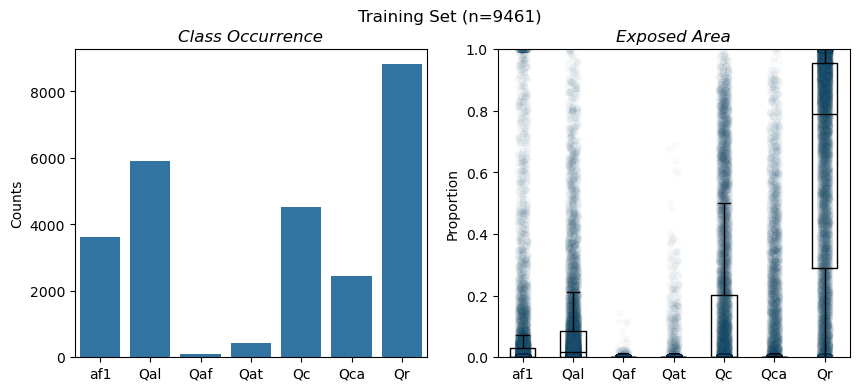

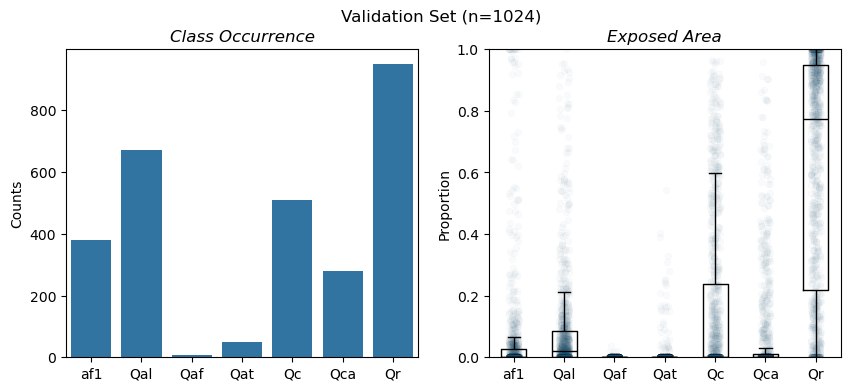

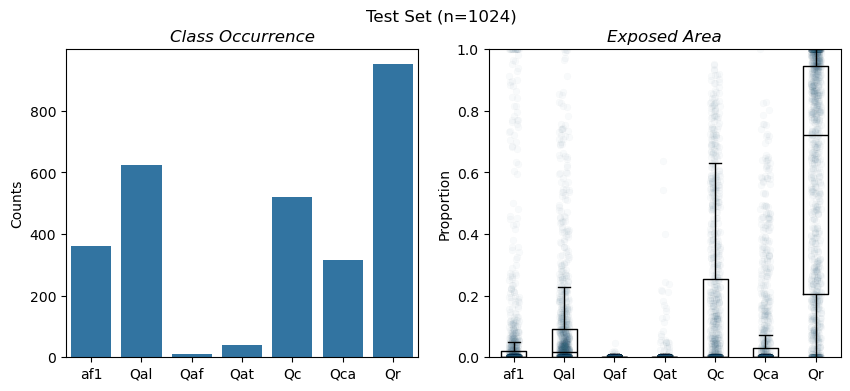

In [8]:
count_path = r'../data/warren/patches_256_50_labels.csv'
area_path = r'../data/warren/patches_256_50_areas.csv'
titles = ['Training Set', 'Validation Set', 'Test Set']
patch_ids = [train_ids, val_ids, test_ids]

for set_name, patches in zip(titles, patch_ids):
    patches = [patch for patch in patches]
    fig = plot_class_distributions(patches, count_path, area_path, set_name)
    fig.savefig(f"../models/classification/model_03/{set_name}_distribution.jpg")
    plt.show(fig)
    

# **Model Training**

In [9]:
#####################
# Confirm GPU Status
#####################

if torch.cuda.is_available():
    print('GPU available...')
else:
    print('GPU NOT available...')

GPU available...


In [10]:
########################
# Training & Validation
########################

# parameters...
output_dir = r'../models/classification/model_03'

num_epochs = 50
out_classes = 7
modality_channels = {'rgb': 3, 'dem': 1}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
optimizer = optim.Adam(model.parameters())

# focal loss...
# target_path = glob.glob(r'../data/warren/*_labels.csv')[0]
# targets = pd.read_csv(target_path)
# targets = targets.iloc[:, 1:]
# alpha = (len(targets) * out_classes) / targets.sum(axis=0).to_numpy()
# alpha = alpha / alpha.sum()
# alpha = np.sqrt(alpha)
# alpha = torch.tensor(alpha, dtype=torch.float32).view(1, -1).to(device)
alpha = 1
gamma = 1
reduction = 'mean'
criterion = FocalLoss(alpha=alpha, gamma=gamma, reduction=reduction)


##### train
train_loss, train_acc, val_loss, val_acc= train_model(model, 
                                                      train_loader, 
                                                      val_loader, 
                                                      criterion, 
                                                      optimizer, 
                                                      device, 
                                                      num_epochs, 
                                                      output_dir)

Epoch 1/50
TRAINING   -- Loss: 0.2120  |  Accuracy: 81.60%  |  Time: 19.58 mins.
VALIDATION -- Loss: 0.2766  |  Accuracy: 82.97%  |  Time: 2.23 mins.
New best model saved with loss 0.2766...
New best model saved with accuracy 82.97%...


Epoch 2/50
TRAINING   -- Loss: 0.1821  |  Accuracy: 83.38%  |  Time: 18.93 mins.
VALIDATION -- Loss: 0.1753  |  Accuracy: 83.26%  |  Time: 2.2 mins.
New best model saved with loss 0.1753...
New best model saved with accuracy 83.26%...


Epoch 3/50
TRAINING   -- Loss: 0.1762  |  Accuracy: 83.92%  |  Time: 17.43 mins.
VALIDATION -- Loss: 0.1974  |  Accuracy: 83.94%  |  Time: 2.03 mins.
New best model saved with accuracy 83.94%...


Epoch 4/50
TRAINING   -- Loss: 0.1718  |  Accuracy: 84.31%  |  Time: 17.23 mins.
VALIDATION -- Loss: 0.1718  |  Accuracy: 84.51%  |  Time: 2.02 mins.
New best model saved with loss 0.1718...
New best model saved with accuracy 84.51%...


Epoch 5/50
TRAINING   -- Loss: 0.1690  |  Accuracy: 84.56%  |  Time: 16.88 mins.
VALIDATIO

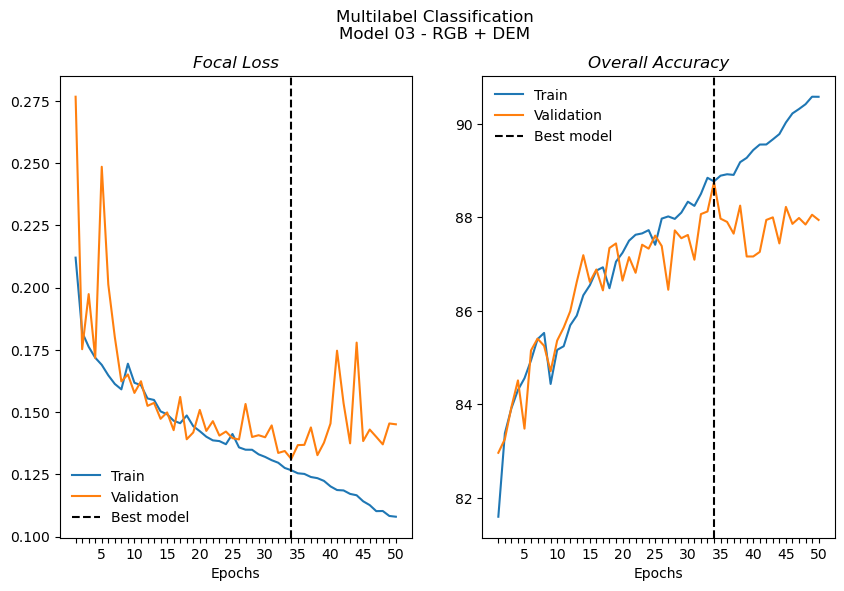

In [16]:

output_path = r'../models/classification/model_03/training.jpg'

best_model = 34


fig, ax = plt.subplots(ncols=2, figsize=(10,6))

epochs = range(1, len(train_loss)+1)

ax[0].plot(epochs, train_loss, label='Train')
ax[0].plot(epochs, val_loss, label='Validation')
ax[0].set_title('Focal Loss', style='italic')

ax[1].plot(epochs, train_acc, label='Train')
ax[1].plot(epochs, val_acc, label='Validation')
ax[1].set_title('Overall Accuracy', style='italic')

for axes in ax:
    axes.axvline(x=best_model, linestyle='--', color='k', label='Best model')
    axes.legend(frameon=False)
    axes.set_xticks(epochs)
    axes.set_xticklabels([str(x) if x%5==0 else '' for x in epochs])
    axes.set_xlabel('Epochs')

plt.suptitle('Multilabel Classification\nModel 03 - RGB + DEM', y=0.99)
plt.savefig(output_path)
plt.show()


# Test

In [17]:
# parameters...
# output_dir = r'../models/classification/model_01'
out_classes = 7
modality_channels = {'rgb': 3, 'dem': 1}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
state_dict = torch.load(r'../models/classification/model_03/best_loss.pth', map_location=device, weights_only=False)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
all_predictions, all_targets = test_model(model, test_loader, device)

## *Per label Metrics*

In [ ]:
##### Precision, Recall, F1, AUC-ROC, Average Precision

In [20]:
df = pd.DataFrame(columns=['MapUnit', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):
    df.loc[idx, 'MapUnit'] = unit
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=0.5)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= 0.5).sum()
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(r'../models/classification/model_03/label_metrics.csv', index=False)
df.head(10)


,MapUnit,Targets,Predictions,Precision,Recall,F1,AUROC
0,af1,361,293,0.7952,0.6454,0.7125,0.8874
1,Qal,624,726,0.7287,0.8478,0.7837,0.7937
2,Qaf,11,0,0.0000,0.0000,0.0000,0.8497
3,Qat,41,2,0.0000,0.0000,0.0000,0.8772
4,Qc,521,479,0.9290,0.8541,0.8900,0.9666
5,Qca,315,248,0.8468,0.6667,0.7460,0.9212
6,Qr,952,995,0.9437,0.9863,0.9646,0.9144


In [17]:
# def plot_label_pr_roc_curves(predictions, targets):
#   fig, ax = plt.subplots(ncols=2, figsize=(10,5))

#   precision_vals, recall_vals, _ = precision_recall_curve(targets, predictions)
#   ax[0].plot(recall_vals, precision_vals, linewidth=2)
#   ax[0].set_xlabel('Recall')
#   ax[0].set_ylabel('Precision')
#   ax[0].set_title('Precision-Recall Curve', style='italic')

#   fpr, tpr, _ = roc_curve(targets, predictions)
#   ax[1].plot(fpr, tpr, linewidth=2)
#   ax[1].plot([0,1], [0,1], color='k', linestyle='--')
#   ax[1].set_xlabel('False Positive Rate')
#   ax[1].set_ylabel('True Positive Rate')
#   ax[1].set_title('Receiver Operating Curve', style='italic')

#   for axes in ax:
#     axes.set_xlim(0,1)
#     axes.set_ylim(0,1)

#   return fig

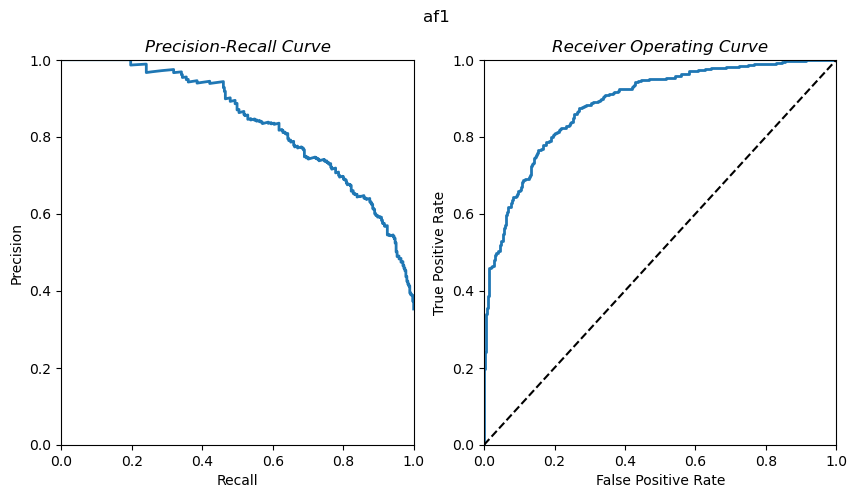

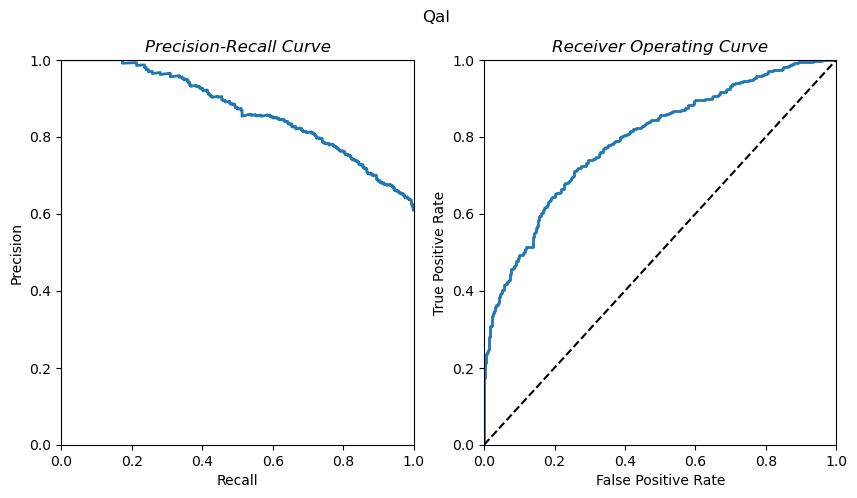

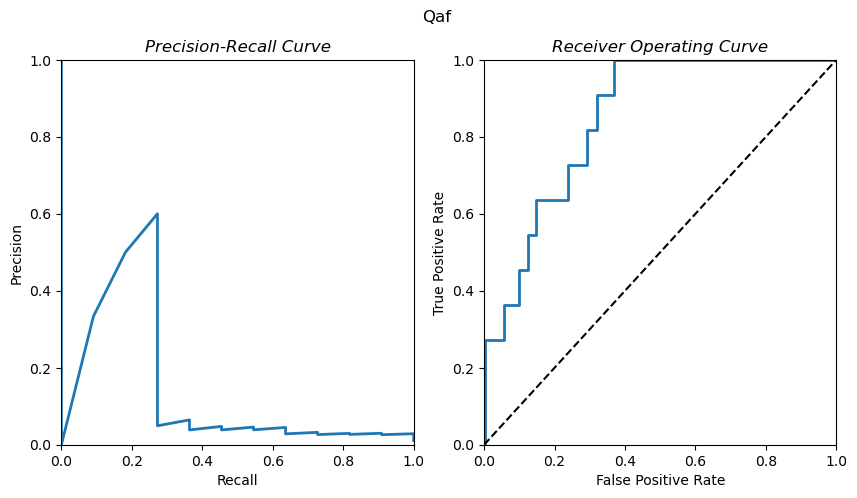

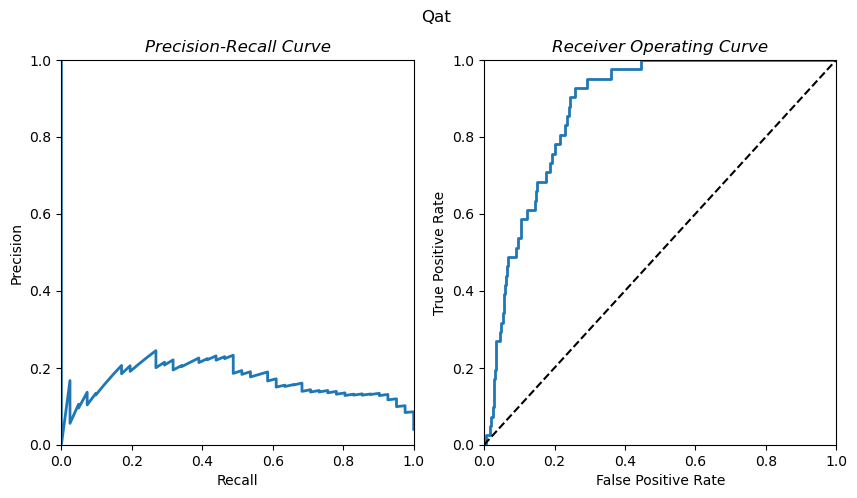

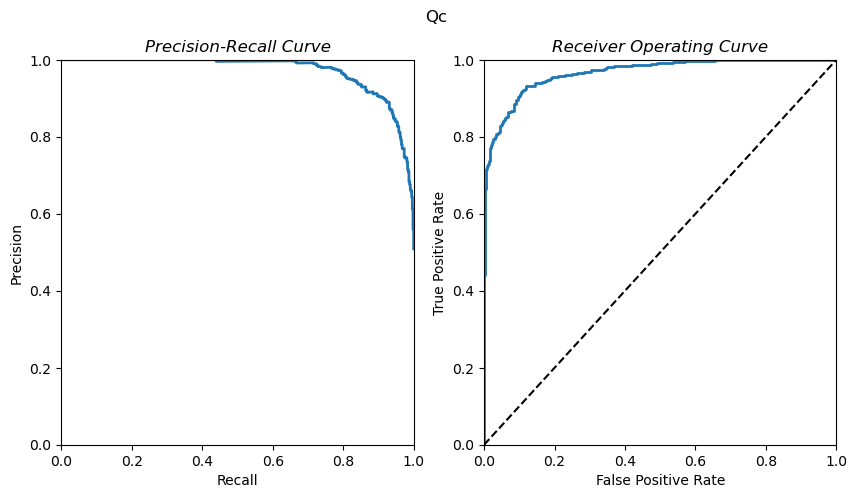

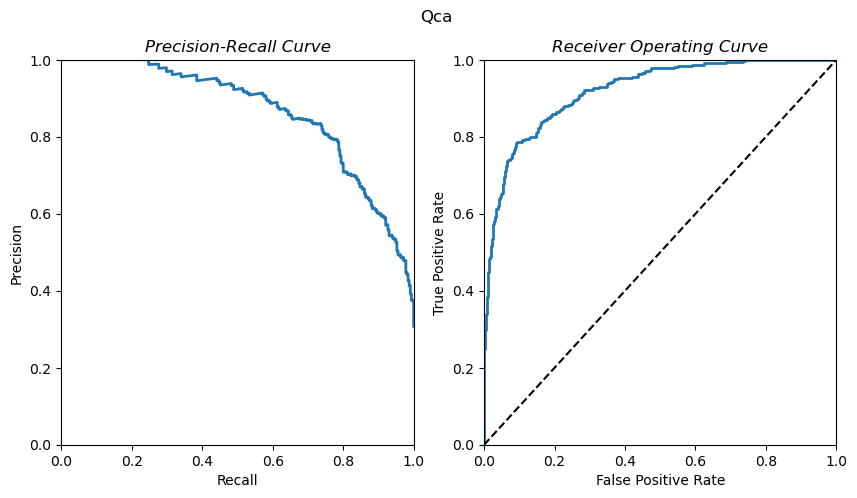

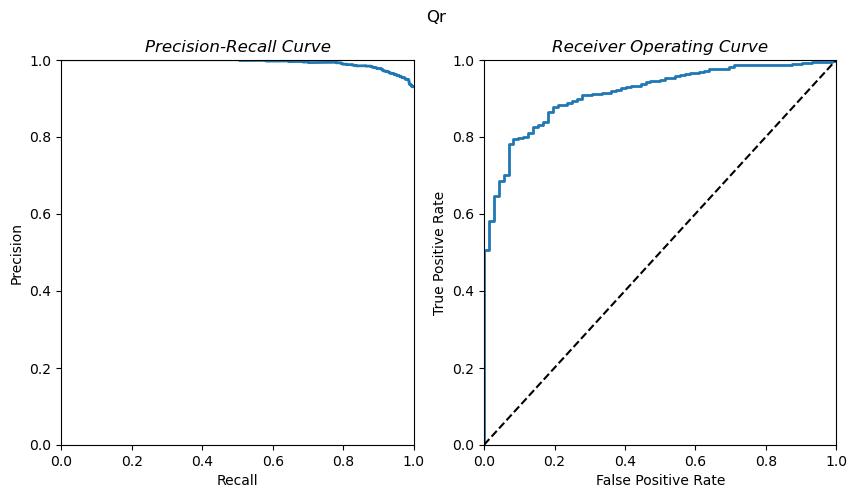

In [21]:
##### Visualizations - Precision-Recall Curve & ROC Curve

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

    fig = plot_label_pr_roc_curves(all_predictions[:,idx], all_targets[:, idx])
    plt.suptitle(unit)
    fig.savefig(f'../models/classification/model_03/{unit}_plots.jpg')
    plt.show(fig)


## *Overall Metrics*

In [22]:
##### Averaged over all labels - Precision, Recall, F1, AUC-ROC, & mean Average Precision (mAP), Hamming loss, Subset Accuracy
macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=[0.5])

df = pd.DataFrame({'MacroPrecision': macro_precision, 
                   'MacroRecall': macro_recall, 
                   'MacroF1': macro_f1, 
                   'mAP': mean_ap, 
                   'HammingLoss': h_loss, 
                   'SubsetAccuracy':subset_acc}, index=[0])

df.to_csv(r'../models/classification/model_03/global_metrics.csv', index=False)
df.head()

c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,MacroPrecision,MacroRecall,MacroF1,mAP,HammingLoss,SubsetAccuracy
0,0.6062,0.5715,0.5853,0.6951,0.1194,0.3994


## *Tuned Results*

In [28]:
def calculate_optimal_thresholds(model, val_loader, device):
  
  all_predictions = []
  all_targets = []

  model.eval()

  with torch.no_grad():
    for batch in val_loader:
      
      labels = batch.pop('label').squeeze(1).to(device)
      modalities = {modality: data.to(device) for modality, data in batch.items()}
      outputs = model(modalities)
      predictions = torch.sigmoid(outputs)
      all_targets.append(labels.cpu().numpy())
      all_predictions.append(predictions.cpu().numpy())
  
  all_predictions = np.concatenate(all_predictions)
  all_targets = np.concatenate(all_targets)

  optimal_thresholds = []

  for class_idx in range (all_predictions.shape[1]):
    precision, recall, thresholds = precision_recall_curve(all_targets[:, class_idx], all_predictions[:, class_idx])
    f1 = 2 * (precision * recall) / (precision + recall)
    best_idx = np.argmax(f1)
    best_threshold = thresholds[best_idx]
    optimal_thresholds.append(best_threshold)

  return optimal_thresholds

In [23]:
optimal_thresholds = calculate_optimal_thresholds(model, val_loader, device)
optimal_thresholds

c:\Users\mamass1\Documents\GitHub\cs612\code\utils_training.py:331: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)
c:\Users\mamass1\Documents\GitHub\cs612\code\utils_training.py:331: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


[0.41788006,
 0.4871445,
 0.4189473,
 0.5534512,
 0.39100426,
 0.45210084,
 0.48792765]

In [24]:
df = pd.DataFrame(columns=['MapUnit', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
    df.loc[idx, 'MapUnit'] = unit + f" ({str(round(thresh, 2))})"
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(r'../models/classification/model_03/label_metrics_tuned.csv', index=False)
df.head(10)

,MapUnit,Targets,Predictions,Precision,Recall,F1,AUROC
0,af1 (0.42),361,389,0.7172,0.7729,0.7440,0.8874
1,Qal (0.49),624,764,0.7081,0.8670,0.7795,0.7937
2,Qaf (0.42),11,0,0.0000,0.0000,0.0000,0.8497
3,Qat (0.55),41,0,0.0000,0.0000,0.0000,0.8772
4,Qc (0.39),521,544,0.8897,0.9290,0.9089,0.9666
5,Qca (0.45),315,274,0.8321,0.7238,0.7742,0.9212
6,Qr (0.49),952,1000,0.9400,0.9874,0.9631,0.9144


In [25]:
macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

df = pd.DataFrame({'MacroPrecision': macro_precision, 
                   'MacroRecall': macro_recall, 
                   'MacroF1': macro_f1, 
                   'mAP': mean_ap, 
                   'HammingLoss': h_loss, 
                   'SubsetAccuracy':subset_acc}, index=[0])

df.to_csv(r'../models/classification/model_03/global_metrics_tuned.csv', index=False)
df.head()

c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,MacroPrecision,MacroRecall,MacroF1,mAP,HammingLoss,SubsetAccuracy
0,0.5839,0.6114,0.5957,0.5528,0.1189,0.3828
